<a href="https://colab.research.google.com/github/ppokranguser/Artificial_Intelligence_study/blob/main/241107_MLP_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages


In [1]:
import os # Provides a way to interact with the operating system, such as file operations.
import csv # Enables reading and writing CSV files, which are commonly used for tabular data.
import numpy as np
from tqdm.notebook import tqdm

# A plotting library for creating visualizations such as charts, histograms, and scatter plots.
import matplotlib.pyplot as plt
# The Python Imaging Library, used for image processing tasks such as opening, manipulating, and saving images.
from PIL import Image

import torch
# provides datasets, transforms, and common architectures for computer vision tasks.
import torchvision
from torchvision import transforms
# Contains neural network layers, loss functions, and utilities for building neural networks.
import torch.nn as nn
# Provides functional interface to neural network operations like activation functions and loss functions.
import torch.nn.functional as F
# Contains optimization algorithms such as SGD, Adam, RMSprop, etc. for training neural networks.
import torch.optim as optim
# Provides utilities for handling datasets and data loading in PyTorch.
from torch.utils.data import Dataset, DataLoader

# Printing PyTorch version
print(torch.__version__)

2.5.0+cu121


### MNIST dataset is provided from Google Colab by default

In [2]:
# Setting paths for train and test data
train_path = './sample_data/mnist_train_small.csv'
test_path = './sample_data/mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [3]:
# Choosing device: GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28x28 for image


In [4]:
# Function to read MNIST dataset from a CSV file
def mnist_reader(file_path, img_size=img_size):
    # Initialize lists to store images and labels
    total_img = list()
    total_label = list()

    # Open the CSV file
    with open(file_path) as csvfile:
        # Create a CSV reader
        mnist_reader = csv.reader(csvfile)
        # Iterate over each row in the CSV file
        for row in mnist_reader:
            # Convert the pixel values to a NumPy array and reshape it to 28x28
            img = np.array(row[1:], dtype=np.uint8).reshape(img_size, img_size)
            # Extract the label from the first element of the row
            label = int(row[0])

            # Append the image and label to their respective lists
            total_img.append(img)
            total_label.append(label)

    # Convert the lists to NumPy arrays
    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)

    return total_img, total_label

In [5]:
# Read the training and testing images and labels using the mnist_reader function
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

print(type(train_img))
print(type(train_label))
print(train_img.shape, train_label.shape)
print(test_img.shape, test_label.shape)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(20000, 28, 28) (20000,)
(10000, 28, 28) (10000,)


### Define the Dataset

In [6]:
# Custom dataset class for MNIST
class MNIST_Dataset(Dataset):
    def __init__(self, img, label):
        # Initialize the dataset with images and labels
        self.img = img
        self.label = label
        # Store the number of data samples
        self.num_data = self.img.shape[0]

    def __len__(self):
        # Return the total number of data samples
        return self.num_data

    def __getitem__(self, idx):
        # Get a sample by its index
        sample = dict()

        # Normalize the image pixel values to the range [0, 1]
        sample['img'] = self.img[idx] / 255
        # Get the corresponding label
        sample['label'] = self.label[idx]

        return sample

### Define the DataLoader

In [7]:
# Set the batch size for training and testing data loaders
batch_size = 64

# Create instances of the MNIST_Dataset class for training and testing datasets
train_dataset = MNIST_Dataset(train_img, train_label)
test_dataset = MNIST_Dataset(test_img, test_label)

# Create DataLoader objects to iterate over batches of data during training and testing
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Sample one data point from dataloader

In [8]:
# Retrieve a batch of data from the test dataloader using the next(iter()) function
sample = next(iter(test_dataloader))

# Print the shape of the image and label tensors in the sampled batch
print(sample['img'].shape)
print(sample['label'].shape)
print(sample['label'])

torch.Size([64, 28, 28])
torch.Size([64])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


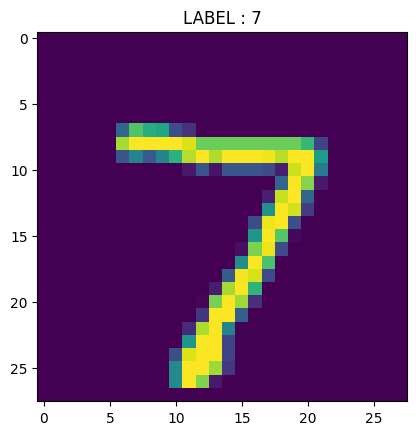

In [9]:
plot_idx = 0
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### Define MLPs function

In [10]:
class MyModel(nn.Module):
    def __init__(self, dim_hid_1=128, dim_hid_2=128, dim_inp=img_size**2, dim_out=10):
        super(MyModel, self).__init__()

        # Initialize the dimensions of hidden layers, input, and output
        self.dim_hid_1 = dim_hid_1
        self.dim_hid_2 = dim_hid_2
        self.dim_inp = dim_inp
        self.dim_out = dim_out

        # Define the activation function (ReLU)
        self.acti = nn.ReLU()

        # Define the first block of the neural network
        self.block_1 = nn.Sequential(nn.Linear(dim_inp, dim_hid_1),
                                     self.acti,
                                     )

        # Define the second block of the neural network
        self.block_2 = nn.Sequential(nn.Linear(dim_hid_1, dim_hid_2),
                                     self.acti,
                                     )

        # Define the final output layer
        self.final_layer = nn.Linear(dim_hid_2, dim_out)

    def forward(self, img):
        # Flatten the input image into a 1D tensor
        batch_size = img.shape[0]
        inp = img.view(batch_size, -1)

        # Pass the input through the first block
        out = self.block_1(inp)

        # Pass the output of the first block through the second block
        out = self.block_2(out)

        # Pass the output of the second block through the final output layer
        out = self.final_layer(out)

        return out

### Create an instance of our MLP model and prepare the optimizer

In [11]:
# Define the model instance of our MLP model.
model = MyModel()

# Move the model to the appropriate device (CPU or GPU).
model = model.to(device)

# Define the optimizer for training the model parameters.
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Define functions for training and testing the model

In [12]:
def train(model, optimizer, sample):
    # Set the model to 'train' mode
    model.train()

    # Define the loss function (cross-entropy loss)
    criterion = nn.CrossEntropyLoss()

    # Extract input image and label from the sample
    img = sample['img'].float().to(device)
    label = sample['label'].long().to(device)

    # Get the model's prediction
    pred = model(img)

    # Count the number of correct predictions
    num_correct = sum(torch.argmax(pred, dim=1) == label)

    # Calculate the loss
    pred_loss = criterion(pred, label)

    # Perform one step of optimization (backward pass, gradient descent)
    optimizer.zero_grad()
    pred_loss.backward()
    optimizer.step()

    # Return the loss value and the number of correct predictions
    return pred_loss.item(), num_correct.item()

In [13]:
def test(model, sample):
    # Set the model to 'evaluation' mode
    model.eval()

    # Define the loss function (cross-entropy loss)
    criterion = nn.CrossEntropyLoss()

    # Extract input image and label from the sample
    img = sample['img'].float().to(device)
    label = sample['label'].long().to(device)

    # Disable gradient calculation for efficiency
    with torch.no_grad():
        # Get the model's prediction
        pred = model(img)

        # Calculate the loss
        pred_loss = criterion(pred, label)

        # Count the number of correct predictions
        num_correct = sum(torch.argmax(pred, dim=1) == label)

    # Return the loss value and the number of correct predictions
    return pred_loss.item(), num_correct.item()

### Run the MLP model

In [ ]:
# Define the maximum number of epochs for training
max_epoch = 100

# Define the frequency of printing the training and testing accuracy during training
print_stride = 10

# Lists to store training and testing losses
tr_loss_saver = []
te_loss_saver = []

# Iterate over each epoch
for epoch in tqdm(range(max_epoch)):
    ### Train Phase

    # Initialize loss and accuracy for training
    train_loss = 0.0
    train_accu = 0.0

    # Iterate over the training data loader
    for idx, sample in enumerate(train_dataloader):
        # Perform one step of training and compute the current loss and number of correct predictions
        curr_loss, num_correct = train(model, optimizer, sample)
        # Accumulate the loss and accuracy
        train_loss += curr_loss / len(train_dataloader)
        train_accu += num_correct / len(train_dataset)

    # Save the training loss
    tr_loss_saver.append(train_loss)

    # Save the current model parameters
    torch.save(model.state_dict(), 'recent.pth')


    ### Test Phase
    # Initialize loss and accuracy for testing
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the testing data loader
    for idx, sample in enumerate(test_dataloader):
        # Compute the current loss and number of correct predictions for testing
        curr_loss, num_correct = test(model, sample)
        # Accumulate the loss and accuracy
        test_loss += curr_loss / len(test_dataloader)
        test_accu += num_correct / len(test_dataset)

    # Save the testing loss
    te_loss_saver.append(test_loss)

    # Print the training and testing accuracy every 'print_stride' epochs
    if (epoch+1) % print_stride == 0:
        print('[epoch {}] train accu :{:.2f} , test accu :{:.2f}'.format(epoch+1, train_accu, test_accu))

  0%|          | 0/100 [00:00<?, ?it/s]

[epoch 10] train accu :0.93 , test accu :0.93
[epoch 20] train accu :0.96 , test accu :0.95
[epoch 30] train accu :0.97 , test accu :0.95
[epoch 40] train accu :0.98 , test accu :0.96
[epoch 50] train accu :0.99 , test accu :0.96
[epoch 60] train accu :0.99 , test accu :0.96
[epoch 70] train accu :1.00 , test accu :0.96
[epoch 80] train accu :1.00 , test accu :0.96
[epoch 90] train accu :1.00 , test accu :0.96


### Plot the train and test loss

In [ ]:
plt.figure(figsize=(4, 3))
plt.plot(tr_loss_saver)  # Plot the training loss
plt.plot(te_loss_saver)  # Plot the testing loss
plt.legend(['Train Loss', 'Test Loss'])  # Add legend to the plot
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.title('Train and Test Loss')  # Title of the plot
plt.show()  # Display the plot